In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

In [ ]:
# default_exp g_models.vae

# all_cuda

# VAE Model

> VAE-type models

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export

from mrl.imports import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.g_models.generative_base import *
from mrl.dataloaders import *

## VAE Models

Variational Autoencoders (VAEs) are a class of generative model that follows an encoder-decoder framework. The encoder maps an input down to a latent vector. The decoder reconstructs the input, and the model is trained on the quality of the reconstruction. VAEs impose a Gaussian prior on the latent space by regularizing the deviation of latent vectors from a unit Gaussian. As a result, we can easily sample valid latent vectors by randomly sampling from a Gaussian distribution.

When dealing with generating text sequences (SMILES, amino acids, etc), we train the model in a self-supervised fashion using next token prediction. In this framework, the decoder module is a conditional LSTM. These models are very similar to the `Conditional_LSTM_LM` model, with the added constraint on the latent space.

During generation, we sample from the model in an autoregression fashion. Given an input token, the model predicts a distribution of tokens over the next token. We then sample from that distribution and feed the selected token back into the model. We repeat this process until either an end of sentence (EOS) token is predicted, or the generated sequence reaches a maximum allowed length.

During sampling, we save the log probability of each token predicted. This gives us a probability value for the model's estimated likelihood of the generated compound. We can also backprop through this value.

## VAE Transition

The `VAE_Transition` class converts an input vector to a valid latent vector. Following standard VAE implementations, the input vector is used to predict a vector of means and a vector of log variances which parameterize a Gaussian distribution. We then use the [Reparametarization Trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/) to sample a latent vector from that distribution.

The module returns the latent vectors and a KL-loss based on the latent distributions deviations from a unit Gaussian.

In [ ]:
# export

class VAE_Transition(nn.Module):
    '''
    VAE_Transition - converts an input vector to 
    a latent vector using the reparametarization trick
    
    Inputs:
    
    - `d_latent int`: latent variable dimensions
    '''
    def __init__(self, d_latent):
        super().__init__()

        self.d_latent = d_latent
        self.transition = nn.Linear(d_latent, d_latent*2)

    def forward(self, x, z_scale=None):
        if z_scale is None:
            z_scale = 1.
        mu, logvar = self.get_stats(x)
        z = z_scale*torch.randn(mu.shape).to(mu.device)
        z = mu + z*torch.exp(0.5*logvar)
        kl_loss = 0.5 * (logvar.exp() + mu.pow(2) - 1 - logvar).sum(1).mean()
        return z, kl_loss

    def get_stats(self, x):
        mu, logvar = torch.chunk(self.transition(x), 2, dim=-1)
        return mu, logvar

## VAE

`VAE` is the base class for VAE models. VAE models consist of a encoder, decoder, and transition modules.

The encoder module maps the model's inputs down to a vector. The model will work with any of the `Encoder` subclasses in the `layers` section. Custom encoders also work so long as they are compatible with the data format you are using and produce a single vector per batch item.

The transition module converts the encoder output to a valid latent vector. By default, VAEs use the `VAE_Transition` which samples a latent vector assuming a target distribution of a unit Gaussian. This can be substituted for any module that returns latent vectors and a KL loss term (0 if not applicable).

The decoder module uses the latent vector to reconstruct the input.

In [ ]:
# export

class VAE(GenerativeModel):
    '''
    VAE - base VAE class
    
    Inputs:
    
    - `encoder nn.Module`: encoder module

    - `decoder nn.Module`: decoder module

    - `prior Optional[nn.Module]`: prior module

    - `bos_idx int`: BOS token

    - `transition Optional[nn.Module]`: transition module

    - `forward_rollout bool`: if True, run supervised training using
    rollout with teacher forcing. This is a technique used in some
    seq2seq models and should not be used for pure generative models

    - `p_force float`: teacher forcing probabiliy

    - `force_decay float`: rate of decay of p_force
    '''
    def __init__(self, 
                 encoder, 
                 decoder, 
                 prior=None, 
                 bos_idx=0, 
                 transition=None,
                 forward_rollout=False, 
                 p_force=0., 
                 force_decay=0.99):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        if transition is None:
            transition = VAE_Transition(encoder.d_latent)
            
        self.transition = transition
        
        if prior is None:
            prior = NormalPrior(torch.zeros((encoder.d_latent)), torch.zeros((encoder.d_latent)),
                                trainable=False)

        self.prior = prior
        
        self.bos_idx = bos_idx
        self.z_scale = 1.
        self.forward_rollout = forward_rollout
        self.p_force = p_force
        self.force_decay = force_decay
        
    def forward(self, decoder_input, encoder_input=None, hiddens=None):
        if encoder_input is None:
            encoder_input = decoder_input
            
        z = self.encoder(encoder_input)
        z, kl_loss = self.transition(z, self.z_scale)
#         output, hiddens, encoded = self.decoder(decoder_input, z, hiddens)
        output, hiddens, encoded = self.decoder_forward(decoder_input, z, hiddens)
        return output, kl_loss
    
    def decoder_forward(self, x, z, hiddens=None):
        '''
        decoder_forward

        If using forward rollout, the model will be sampled
        from at each time step. The model has a `p_force` chance
        to recieve the correct next input, and a `1-p_force`
        chance to recieve the model's own prediction.

        If forward rollout is not used, `x` and `z` are
        simply passed to the decoder
        '''
        if self.forward_rollout:
#             current_device = next(self.parameters()).device
            sl = x.shape[1]
            bs = x.shape[0]
            
#             start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
#             idxs = to_device(start_idx, device=current_device)
            idxs = x[:,0].unsqueeze(-1)
            
            output = []
            encoded = []
            
            for i in range(sl):
                output_iter, hiddens, encoded_iter = self.decoder(idxs,z,hiddens)
                output.append(output_iter)
                encoded.append(encoded_iter)
                
                if np.random.random()<self.p_force:
                    idxs = x[:,i].unsqueeze(-1)
                    
                else:
                    with torch.no_grad():
                        idxs = F.softmax(output_iter,-1).argmax(-1)
                        
            output = torch.cat(output, 1)
            encoded = torch.cat(encoded, 1)
            self.p_force = self.p_force * self.force_decay
            
        else:
            output, hiddens, encoded = self.decoder(x, z, hiddens)
            
        return output, hiddens, encoded
    
    def unpack_x(self, x):
        if isinstance(x, (list, tuple)):
            decoder_input, encoder_input = x
        else:
            encoder_input = x
            decoder_input = x
        
        return decoder_input, encoder_input
        
    def x_to_latent(self, x):
        decoder_input, encoder_input = self.unpack_x(x)
        
        z = self.encoder(encoder_input)
        z,_ = self.transition(z, self.z_scale)
        return z
        
    def sample(self, bs, sl, z=None, temperature=1., multinomial=True, z_scale=1.):
        '''
        sample - sample from the model

        Inputs:
        
        - `bs int`: batch size

        - `sl int`: maximum sequence length

        - `z Optional[torch.Tensor[bs, d_latent]]`: latent vector

        - `temperature float`: sample temperature

        - `multinomial bool`: if True, use multinomial sampling.
        If False, use argmax greedy sampling

        Returns:

        - `preds torch.LongTensor[bs, sl]`: predicted sequence tokens

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: prediction log probabilities
        '''
        
        current_device = next(self.parameters()).device
        
        start_idx = torch.tensor([self.bos_idx]*bs).long().unsqueeze(-1)
        
        preds = idxs = to_device(start_idx, device=current_device)
        
        lps = []
        
        if z is None:
            if self.prior is not None:
                z = to_device(self.prior.rsample([bs]), device=current_device)
            else:
                prior = Normal(torch.zeros((self.encoder.d_latent)),
                               torch.ones((self.encoder.d_latent)))
                z = to_device(self.prior.rsample([bs]), device=current_device)
        else:
            bs = z.shape[0]
        
        hiddens = None
        
        for i in range(sl):
            x, hiddens, encoded = self.decoder(idxs, z, hiddens)
            x.div_(temperature)
            
            idxs, lp = x_to_preds(x, multinomial=multinomial)
            
            lps.append(lp)            
            preds = torch.cat([preds, idxs], -1)
            
        return preds[:, 1:], torch.cat(lps,-1)
        
    def sample_no_grad(self, bs, sl, z=None, temperature=1., multinomial=True):
        '''
        sample_no_grad - sample from the model without saving values for
        gradient calculation

        Inputs:

        - `bs int`: batch size

        - `sl int`: maximum sequence length

        - `z Optional[torch.Tensor[bs, d_latent]]`: latent vector

        - `temperature float`: sample temperature

        - `multinomial bool`: if True, use multinomial sampling.
        If False, use argmax greedy sampling

        Returns:

        - `preds torch.LongTensor[bs, sl]`: predicted sequence tokens

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: prediction log probabilities
        '''
        with torch.no_grad():
            return self.sample(bs, sl, z=z, temperature=temperature, multinomial=multinomial)
        
    def get_rl_tensors(self, x, y, temperature=1., latent=None):
        '''
        get_rl_tensors - generate values needed for RL training

        Inputs:
        
        - `x torch.LongTensor[bs, sl]`: x value

        - `y torch.LongTensor[bs, sl]`: y value

        - `temperature float`: sample temperature

        - `latent Optonal[torch.FloatTensor[bs, d_latent]]`: latent vector

        Returns:

        - `output torch.FloatTensor[bs, sl, d_vocab]`: output of the model

        - `lps torch.FloatTensor[bs, sl, d_vocab]`: log probabilities.
        Log softmax of `output` values

        - `lps_gathered torch.FloatTensor[bs, sl]`: log probabilities
        gathered by the values in `y`

        - `encoded torch.FloatTensor[bs, sl, d_embedding]`: output from
        final LSTM layer
        '''
        
        decoder_input, encoder_input = self.unpack_x(x)
            
        if latent is None:
            latent = self.encoder(encoder_input)
            latent,_ = self.transition(latent)
            
        output, hiddens, encoded = self.decoder(decoder_input, latent)
        
        output.div_(temperature)
        lps = F.log_softmax(output, -1)

        if self.prior.trainable:
            prior_lps = self.prior.log_prob(z)
            prior_lps = prior_lps.mean(-1).unsqueeze(-1).unsqueeze(-1)
            pass_through = torch.zeros(prior_lps.shape).float().to(prior_lps.device)
            pass_through = pass_through + prior_lps - prior_lps.detach() # add to gradient chain
            lps = lps + pass_through
            
        lps_gathered = gather_lps(lps, y)
        return output, lps, lps_gathered, encoded
    
    def set_prior_from_stats(self, mu, logvar, trainable=False):
        '''
        set_prior_from_latent - set prior distribution
        from `mu` and `logvar` 

        Inputs:

        - `mu torch.FloatTensor[bs, d_latent]`: vector of means

        - `logvar torch.FloatTensor[bs, d_latent]`: vector of log variances

        - `trainable bool`: if True, prior will be updated by gradient descent
        '''
        mu = mu.detach()
        logvar = logvar.detach()
        self.prior = NormalPrior(mu, logvar, trainable)
        
    def set_prior_from_latent(self, z, trainable=False):
        '''
        set_prior_from_latent - set prior distribution
        from `z` 

        Inputs:

        - `z torch.FloatTensor[bs, d_latent]`: latent vector

        - `trainable bool`: if True, prior will be updated by gradient descent
        '''
        mu, logvar = self.transition.get_stats(z)
        self.set_prior_from_stats(mu, logvar, trainable)
        
    def set_prior_from_encoder(self, x, trainable=False):
        '''
        set_prior_from_encoder - computes a latent vector
        from `condition` and uses it to set the model's prior

        Inputs:

        - `x`: input value (depends on encoder)

        - `trainable bool`: if True, prior will be updated by gradient descent
        '''
        decoder_input, encoder_input = self.unpack_x(x)
        assert encoder_input.shape[0]==1, "Must set prior from a single input"
        z = self.encoder(encoder_input)
        z = z.squeeze(0)
        self.set_prior_from_latent(z, trainable)

In [ ]:
encoder = LSTM_Encoder(32, 64, 128, 2, 128)
decoder = Conditional_LSTM_Block(32, 64, 128, 64, 128, 2,
                                condition_hidden=True, condition_output=True)
vae = VAE(encoder, decoder)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

_ = vae(x)

In [ ]:
decoder = Conditional_LSTM_Block(32, 64, 128, 64, 128, 2,
                                condition_hidden=False, condition_output=True)
vae = VAE(encoder, decoder)

_ = vae(x)

In [ ]:
decoder = Conditional_LSTM_Block(32, 64, 128, 64, 128, 2,
                                condition_hidden=True, condition_output=False)
vae = VAE(encoder, decoder)

_ = vae(x)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

o,lp,lpg,e = vae.get_rl_tensors(x,y)

In [ ]:
vae.set_prior_from_encoder(x[0].unsqueeze(0), trainable=True);

o,lp,lpg,e = vae.get_rl_tensors(x,y)
loss = lpg.mean()
assert vae.prior.loc.grad is None
loss.backward()
assert vae.prior.loc.grad is not None

latent = torch.randn((x.shape[0], 128))
o,lp,lpg,e = vae.get_rl_tensors(x,y,latent=latent)

## Preset VAEs

The following modules are preset encoder-decoder configurations.

`LSTM_VAE` has a LSTM encoder and a conditional LSTM decoder. This works for most sequence to sequence type tasks.

`Conv_VAE` replaces the LSTM encoder with a 1D conv encoder (the model is still intended for sequences, not 2D images). The convolutional encoder tends to be faster and lighter than the LSTM encoder. Anecdotally, it seems to perform better than the LSTM encoder.

`MLP_VAE` uses a MLP encoder. This model works best for reconstructing a sequence from a fingerprint, property vector, or something similar.

In [ ]:
# export

class LSTM_VAE(VAE):
    '''
    LSTM_VAE - VAE with LSTM encoder and conditional LSTM decoder. 
    Usable for text-to-text or seq-2-seq tasks or similar
    
    Inputs:
    
    
    - `d_vocab int`: vocab size

    - `d_embedding int`: embedding dimension

    - `d_hidden int`: hidden dimension
    
    - `n_layers int`: number of LSTM layers (same for encoder and decoder)

    - `d_latent int`: latent vector dimension

    - `input_dropout float`: dropout percentage on inputs

    - `lstm_dropout float`: dropout on LSTM layers

    - `condition_hidden bool`: if True, latent vector is used to initialize the
    hidden state

    - `condition_output bool`: if True, latent vector is concatenated to inputs

    - `prior Optional[nn.Module]`: optional prior distribution to sample from.
    see `Prior`
    
    - `bos_idx int`: beginning of sentence token
    
    
    - `transition Optional[nn.Module]`: transition module

    - `forward_rollout bool`: if True, run supervised training using
    rollout with teacher forcing. This is a technique used in some
    seq2seq models and should not be used for pure generative models

    - `p_force float`: teacher forcing probabiliy

    - `force_decay float`: rate of decay of p_force
        
    '''
    
    def __init__(self, 
                 d_vocab, 
                 d_embedding, 
                 d_hidden, 
                 n_layers, 
                 d_latent,
                 input_dropout=0., 
                 lstm_dropout=0., 
                 condition_hidden=True, 
                 condition_output=True,
                 prior=None, bos_idx=0, 
                 transition=None,
                 forward_rollout=False, 
                 p_force=0., 
                 force_decay=0.99):
        
        encoder = LSTM_Encoder(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                n_layers,
                                d_latent,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout
                            )
        
        decoder = Conditional_LSTM_Block(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                d_embedding,
                                d_latent,
                                n_layers,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout,
                                bidir=False,
                                condition_hidden=condition_hidden,
                                condition_output=condition_output,
                            )
        
        
        super().__init__(encoder, decoder, prior, bos_idx, transition,
                        forward_rollout, p_force, force_decay)

In [ ]:
vae = LSTM_VAE(32, 64, 128, 2, 128, condition_hidden=True, condition_output=True)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

_ = vae(x)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

_ = vae.get_rl_tensors(x,y)

In [ ]:
# export

class Conv_VAE(VAE):
    '''
    Conv_VAE - VAE with 1D Conv encoder and conditional LSTM decoder. 
    Usable for text-to-text or seq-2-seq tasks or similar
    
    Inputs:
    
    - `d_vocab int`: vocab size

    - `d_embedding int`: embedding dimension

    - `conv_filters list[int]`: filter sizes for conv layers ie `[64, 128, 256]`

    - `kernel_sizes list[int]`: kernel sizes for conv layers ie `[5, 5, 5]`

    - `strides list[int]`: strides for conv layers ie `[2, 2, 2]`

    - `conv_drops list[float]`: list of dropout pobabilities ie `[0.2, 0.2, 0.3]`

    - `d_hidden int`: hidden dimension

    - `n_layers int`: number of LSTM layers (same for encoder and decoder)

    - `d_latent int`: latent variable dimension

    - `input_dropout float`: dropout percentage on inputs

    - `lstm_dropout float`: dropout on LSTM layers

    - `condition_hidden bool`: if True, latent vector is used to initialize the
    hidden state

    - `condition_output bool`: if True, latent vector is concatenated to
    the outputs of the embedding layer

    - `prior Optional[nn.Module]`: prior module

    - `bos_idx int`: BOS token

    - `transition Optional[nn.Module]`: transition module

    - `forward_rollout bool`: if True, run supervised training using
    rollout with teacher forcing. This is a technique used in some
    seq2seq models and should not be used for pure generative models

    - `p_force float`: teacher forcing probabiliy

    - `force_decay float`: rate of decay of p_force
        
    '''
    def __init__(self, 
                 d_vocab, 
                 d_embedding, 
                 conv_filters, 
                 kernel_sizes, 
                 strides, 
                 conv_drops,
                 d_hidden, 
                 n_layers, 
                 d_latent, 
                 input_dropout=0., 
                 lstm_dropout=0.,
                 condition_hidden=True, 
                 condition_output=True,
                 prior=None, 
                 bos_idx=0, 
                 transition=None,
                 forward_rollout=False, 
                 p_force=0., 
                 force_decay=0.99):
        
        encoder = Conv_Encoder(
                                d_vocab,
                                d_embedding,
                                d_latent,
                                conv_filters,
                                kernel_sizes,
                                strides,
                                conv_drops,
                            )
        
        decoder = Conditional_LSTM_Block(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                d_embedding,
                                d_latent,
                                n_layers,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout,
                                bidir=False,
                                condition_hidden=condition_hidden,
                                condition_output=condition_output,
                            )
        
        super().__init__(encoder, decoder, prior, bos_idx, transition,
                        forward_rollout, p_force, force_decay)

In [ ]:
vae = Conv_VAE(32, 64, [128, 256], [7,7], [2,2], [0.1,0.1], 128, 2, 128, 
               condition_hidden=False, condition_output=True)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

_ = vae(y,x)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

_ = vae.get_rl_tensors(x,y)

In [ ]:
# export
        
class MLP_VAE(VAE):
    '''
    MLP_VAE - VAE with MLP encoder and conditional LSTM decoder. 
    Usable for reconstructing a sequence from a vector
    
    Inputs:
    
    - `d_vocab int`: vocab size

    - `d_embedding int`: embedding dimension

    - `encoder_d_in int`: encoder input dimension

    - `encoder_dims list[int]`: list of encoder layer sizes ie `[1024, 512, 256]`

    - `encoder_drops list[float]`: list of dropout pobabilities ie `[0.2, 0.2, 0.3]`

    - `d_hidden int`: hidden dimension

    - `n_layers int`: number of LSTM layers (same for encoder and decoder)

    - `d_latent int`: latent variable dimension

    - `input_dropout float`: dropout percentage on inputs

    - `lstm_dropout float`: dropout on LSTM layers

    - `condition_hidden bool`: if True, latent vector is used to initialize the
    hidden state

    - `condition_output bool`: if True, latent vector is concatenated to
    the outputs of the embedding layer

    - `prior Optional[nn.Module]`: prior module

    - `bos_idx int`: BOS token

    - `transition Optional[nn.Module]`: transition module

    - `forward_rollout bool`: if True, run supervised training using
    rollout with teacher forcing. This is a technique used in some
    seq2seq models and should not be used for pure generative models

    - `p_force float`: teacher forcing probabiliy

    - `force_decay float`: rate of decay of p_force
        
    '''
    def __init__(self, 
                 d_vocab, 
                 d_embedding, 
                 encoder_d_in, 
                 encoder_dims, 
                 encoder_drops,
                 d_hidden, 
                 n_layers, 
                 d_latent, 
                 input_dropout=0., 
                 lstm_dropout=0.,
                 condition_hidden=True, 
                 condition_output=True,
                 prior=None, 
                 bos_idx=0, 
                 transition=None,
                 forward_rollout=False, 
                 p_force=0., 
                 force_decay=0.99):
        
        
        encoder = MLP_Encoder(encoder_d_in, encoder_dims, d_latent, encoder_drops)
        
        decoder = Conditional_LSTM_Block(
                                d_vocab,
                                d_embedding,
                                d_hidden,
                                d_embedding,
                                d_latent,
                                n_layers,
                                input_dropout=input_dropout,
                                lstm_dropout=lstm_dropout,
                                bidir=False,
                                condition_hidden=condition_hidden,
                                condition_output=condition_output,
                            )
        
        super().__init__(encoder, decoder, prior, bos_idx, transition,
                        forward_rollout, p_force, force_decay)
    
    

In [ ]:
vae = MLP_VAE(32, 64, 128, [64, 32], [0.1, 0.1], 128, 2, 128, 
               condition_hidden=False, condition_output=True)

ints = torch.randint(0, 31, (8, 10))
x = ints[:,:-1]
y = ints[:,1:]

condition = torch.randn((8,128))


_ = vae(x, condition)

_ = vae.sample(8, 16)

z = vae.prior.sample([8])
_ = vae.sample(8, 16, z=z)

_ = vae.get_rl_tensors([x, condition],y)

In [ ]:
# export

class VAELoss():
    '''
    VAELoss - loss for VAE models
    
    Inputs:
    
    - `weight float`: KL loss weight
    '''
    def __init__(self, weight=1.):
        self.ce = CrossEntropy()
        self.weight = weight
        
    def __call__(self, inputs, targs):
        output, kl_loss = inputs
        return self.ce(output, targs) + self.weight*kl_loss

In [ ]:
# export

def vae_seq2seq_collate(batch, pad_idx, batch_first=True):
    x,y = lm_collate(batch, pad_idx, batch_first)
    output = ((y,x),y)
    return output

In [ ]:
# export

class VAE_Seq2Seq_Dataset(Text_Dataset):
    '''
    VAE_Seq2Seq_Dataset - seq to seq dataset for VAEs
    
    Inputs:
    
    - `sequences - list[tuple]`: list of text tuples (source, target)
        
    - `vocab - Vocab`: vocabuary for tokenization/numericaization
        
    - `collate_function Callable`: batch collate function. 
    If None, defauts to `vae_seq2seq_collate`
    '''
    def __init__(self, sequences, vocab, collate_function=None):
        if collate_function is None:
            collate_function = partial(vae_seq2seq_collate, pad_idx=vocab.stoi['pad'])
            
        super().__init__(sequences, vocab, collate_function)

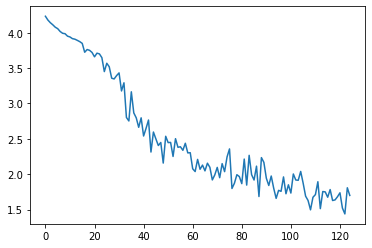

In [ ]:
# slow

# text reconstruction

from mrl.vocab import *
from mrl.dataloaders import *

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(df.smiles.values, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']

model = LSTM_VAE(
                d_vocab,
                d_embedding,
                d_hidden,
                n_layers,
                d_latent,
                input_dropout=0.0,
                lstm_dropout=0.0,
                condition_hidden=condition_hidden,
                condition_output=condition_output,
                prior=None,
                bos_idx=bos_idx,
                transition=None,
            )


to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

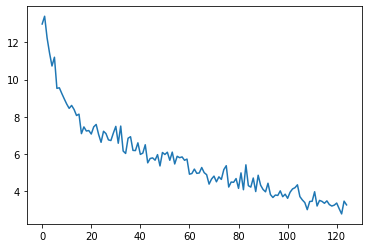

In [ ]:
# slow

# text reconstruction conv

from mrl.vocab import *
from mrl.dataloaders import *

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(df.smiles.values, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
conv_filters = [128, 256, 512]
kernel_sizes = [7,7,7]
strides = [2,2,2]
conv_drops = [0.3, 0.3, 0.3]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']

model = Conv_VAE(
                d_vocab,
                d_embedding,
                conv_filters,
                kernel_sizes,
                strides,
                conv_drops,
                d_hidden,
                n_layers,
                d_latent,
                input_dropout=input_dropout,
                lstm_dropout=lstm_dropout,
                condition_hidden=condition_hidden,
                condition_output=condition_output,
                prior=None,
                bos_idx=bos_idx,
                transition=None,
            )


to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


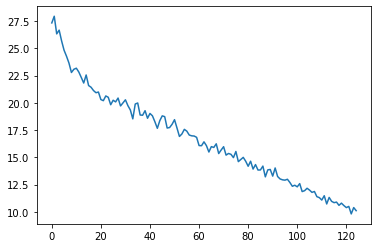

In [ ]:
# slow

# vector to text

from mrl.vocab import *
from mrl.dataloaders import *
from mrl.chem import ECFP6

df = pd.read_csv('files/smiles.csv')
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
        )

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

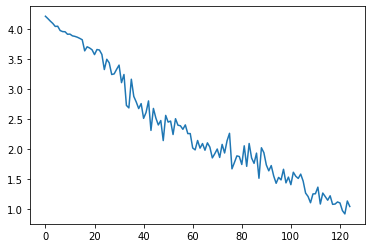

In [ ]:
# slow

# text to text

from mrl.vocab import *
from mrl.dataloaders import *
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = VAE_Seq2Seq_Dataset(smiles, vocab)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']

model = LSTM_VAE(
                d_vocab,
                d_embedding,
                d_hidden,
                n_layers,
                d_latent,
                input_dropout=0.0,
                lstm_dropout=0.0,
                condition_hidden=condition_hidden,
                condition_output=condition_output,
                prior=None,
                bos_idx=bos_idx,
                transition=None,
            )


to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

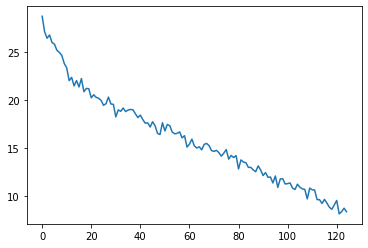

In [ ]:
# slow

# vec to text

from mrl.vocab import *
from mrl.dataloaders import *
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)


ds = Vec_To_Text_Dataset(smiles, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
        )

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

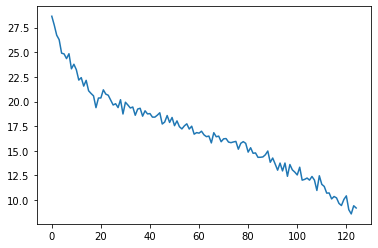

In [ ]:
# slow

# vec to text with rollout

from mrl.vocab import *
from mrl.dataloaders import *
from rdkit.Chem.Scaffolds import MurckoScaffold
from mrl.chem import to_mol, to_smile


df = pd.read_csv('files/smiles.csv')
source_smiles = [to_smile(MurckoScaffold.GetScaffoldForMol(to_mol(i))) for i in df.smiles.values]
target_smiles = df.smiles.values
smiles = [(source_smiles[i], target_smiles[i]) for i in range(len(source_smiles))]

vocab = CharacterVocab(SMILES_CHAR_VOCAB)


ds = Vec_To_Text_Dataset(smiles, vocab, ECFP6)
dl = ds.dataloader(16, num_workers=0)
loss = VAELoss()

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
d_latent = 512
n_layers = 3
input_dropout = 0.3
lstm_dropout = 0.3
bidir = False
condition_hidden = True
condition_output = True
bos_idx = vocab.stoi['bos']
forward_rollout=True
p_force=1.
force_decay=0.9


model = MLP_VAE(
            d_vocab,
            d_embedding,
            encoder_d_in,
            encoder_dims,
            encoder_drops,
            d_hidden,
            n_layers,
            d_latent,
            input_dropout=input_dropout,
            lstm_dropout=lstm_dropout,
            condition_hidden=condition_hidden,
            condition_output=condition_output,
            prior=None,
            bos_idx=bos_idx,
            transition=None,
            forward_rollout=forward_rollout,
            p_force=p_force,
            force_decay=force_decay
        )

to_device(model)

opt = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
                                    steps_per_epoch=len(dl), epochs=10)

losses = []

for i, batch in enumerate(dl):
    batch = to_device(batch)
    x,y = batch
    preds = model(*x)
    batch_loss = loss(preds, y)
    opt.zero_grad()
    batch_loss.backward()
    opt.step()
    scheduler.step()
    losses.append(batch_loss.item())
    
plt.plot(losses)

In [ ]:
# hide
from nbdev.export import notebook2script; notebook2script()